In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [2]:
import numpy as np
x = np.load("training2_x.npy")
y = np.load("training2_y.npy")

In [3]:
# reshape and normalization
x = x.reshape(6452,4,2048)

means1 = x[:,1,:].mean()
stds1 = x[:,1,:].std()
x1 = (x[:,1,:].squeeze() - means1) / (stds1)

means3 = x[:,3,:].mean()
stds3 = x[:,3,:].std()
x3 = (x[:,3,:].squeeze() - means3) / (2*stds3)

x0 = x[:,0,:].squeeze() / 2048
x2 = x[:,2,:].squeeze() / 2048

x = np.hstack((x0,x1,x2,x3))
x = x[:,np.newaxis,:]

In [4]:
# y_temp = np.zeros((y.shape[0],3))
# rows = np.arange(y.size)
# y_temp[rows, y] = 1
# y = y_temp

In [5]:
X_train = x[:5162,:]
X_test = x[5162:6452,:]
y_train = y[:5162]
y_test = y[5162:6452]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5162, 1, 8192), (1290, 1, 8192), (5162,), (1290,))

In [6]:
def data_gen(input, window_size):
  if len(input.shape) > 1:
    input = input.squeeze()
    output = np.zeros(((input.shape[0] - window_size+1), window_size, input.shape[1]) )
    for i in range(input.shape[0] - window_size+1):
      output[i:i+1, :, :] = input[np.newaxis,i:(i+window_size),:]
  elif len(input.shape) == 1:
    output = np.zeros(((input.shape[0] - window_size+1), window_size) )
    for i in range(input.shape[0] - window_size+1):
      output[i:i+1, :] = input[np.newaxis,i:(i+window_size)]
  return output

In [7]:
X_train = data_gen(X_train, 10)
X_test = data_gen(X_test, 10)
# y_train = data_gen(y_train, 10)
# y_test = data_gen(y_test, 10)
y_train = y_train[9:]
y_test = y_test[9:]

In [8]:
import torch
import torch.nn as nn
from torch.autograd import Variable

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.LongTensor(y_train))
y_test_tensors = Variable(torch.LongTensor(y_test)) 
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5153, 10, 8192), (1281, 10, 8192), (5153,), (1281,))

In [9]:

class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #The number of expected features in the input x
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        # self.fcn1 =  nn.Linear(hidden_size, 100) #fully connected 1
        # self.relu1 = nn.ReLU()
        # self.fcn2 =  nn.Linear(100, num_classes) #fully connected 1
        # self.relu2 = nn.ReLU()
        self.fcn =  nn.Linear(hidden_size, num_classes) #fully connected 1
        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        # output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        output, (hn, cn) = self.lstm(x)

        # testing
        print
        hn = hn[-1,:,:].view(-1, self.hidden_size) #reshaping the data for Dense layer next
        # out = self.relu1(hn)
        # out = self.fcn1(out)
        # out = self.relu2(out)
        # out = self.fcn2(out)
        out = self.relu(hn)
        out = self.fcn(out)

        return out

In [10]:
num_epochs = 10 #1000 epochs
learning_rate = 0.001 #0.001 lr
input_size = 8192 #number of features
hidden_size = 400 #number of features in hidden state
num_layers = 3 #number of stacked lstm layers
num_classes = 3 #number of output classes 
seq_length = 1
window_size = 200

lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, seq_length)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

In [11]:
for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors) #forward pass
  # print(outputs.shape)
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0

  # obtain the loss function
  print(outputs.shape)
  loss = criterion(outputs, y_train_tensors)

  loss.backward() #calculates the loss of the loss function

  optimizer.step() #improve from loss, i.e backprop
  if epoch % 1 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

torch.Size([5153, 3])
Epoch: 0, loss: 1.09908
torch.Size([5153, 3])
Epoch: 1, loss: 1.01986
torch.Size([5153, 3])
Epoch: 2, loss: 0.91373
torch.Size([5153, 3])
Epoch: 3, loss: 0.98354
torch.Size([5153, 3])
Epoch: 4, loss: 0.87163
torch.Size([5153, 3])
Epoch: 5, loss: 0.86993
torch.Size([5153, 3])
Epoch: 6, loss: 0.84749
torch.Size([5153, 3])
Epoch: 7, loss: 0.80422
torch.Size([5153, 3])
Epoch: 8, loss: 0.76234
torch.Size([5153, 3])
Epoch: 9, loss: 0.73124


### TODO

In [ ]:
for epoch in range(num_epochs):
  for win in range(X_train_tensors.shape[0] - window_size + 1):
    outputs = lstm1.forward(X_train_tensors[win:win+window_size,:,:]) #forward pass
    # print(outputs.shape)
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0
  
    # obtain the loss function
    loss = criterion(outputs, y_train_tensors[win:win+window_size])
  
    loss.backward() #calculates the loss of the loss function
  
    optimizer.step() #improve from loss, i.e backprop
  if epoch % 1 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

# TEST

In [12]:
rst = lstm1.forward(X_test_tensors)
y_pred = torch.argmax(rst, dim=1)
torch.eq(y_pred, y_test_tensors).sum()/y_pred.shape[0]

tensor(0.5722)

[Text(42.0, 0.5, 'True Value'), Text(0.5, 42.0, 'Predicted Value')]

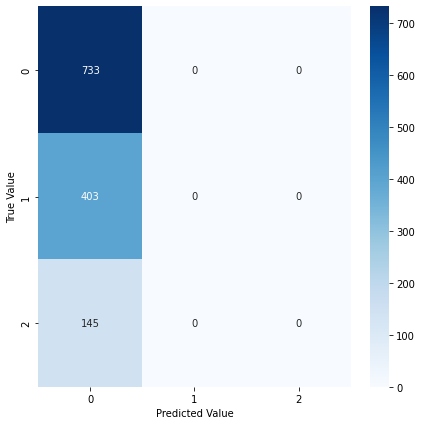

In [15]:
import sklearn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(confusion_matrix, index = [0,1,2], columns = [0,1,2])
plt.figure(figsize = (7,7))
s = sn.heatmap(df_cm, annot=True, fmt='g',cmap='Blues')
s.set(xlabel='Predicted Value', ylabel='True Value')

In [ ]:
tst = torch.zeros(y_test_tensors.shape[0])
torch.eq(tst, y_test_tensors).sum()/tst.shape[0]

tensor(0.5618)

In [ ]:
l = 0
for i in range(1,y.shape[0]):
  if y[i] != y[i-1]:
    print(i-l)
    l = i

# TODO: CNN

In [ ]:
import torch.nn as nn

# the VGG11 architecture
class VGG11(nn.Module):
    def __init__(self, in_channels, num_classes=3):
        super(VGG11, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        # convolutional layers 
        self.conv_layers = nn.Sequential(
            nn.Conv2d(self.in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # fully connected linear layers
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=512*7*7, out_features=4096),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(in_features=4096, out_features=self.num_classes)
        )
    def forward(self, x):
        x = self.conv_layers(x)
        # flatten to prepare for the fully connected layers
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return 